<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Знакомство-с-данными-и-анализ" data-toc-modified-id="Знакомство-с-данными-и-анализ-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Знакомство с данными и анализ</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-KNeighborsClassifier" data-toc-modified-id="Модель-KNeighborsClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель KNeighborsClassifier</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель CatBoost</a></span></li><li><span><a href="#Анализ-лучшей-модели" data-toc-modified-id="Анализ-лучшей-модели-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Анализ лучшей модели</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нам предстоит обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Ход выполнения проекта**

1. Загрузим и подготовим данные.
2. Обучим разные модели. 
3. Сделаем выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`.
* Столбец *text* содержит текст комментария
* Столбец *toxic* — целевой признак

In [1]:
# установим недостающие библиотеки

!pip install -U spacy -q # -q убирает необязательные выводы в командах Linux
!python -m spacy download en_core_web_sm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.7.3 which is incompatible.
     |████████████████████████████████| 12.8 MB 1.4 MB/s eta 0:00:01
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.2.0
    Uninstalling en-core-web-sm-3.2.0:
      Successfully uninstalled en-core-web-sm-3.2.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# загрузим необходимые библиотеки:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter("ignore") # скроем предупреждения перед финальным запуском тетрадки

## Подготовка

### Знакомство с данными и анализ
Загрузим данные и ознакомимся с ними.

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
df_copy = df

In [4]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
df.shape

(159292, 2)

Посмотрим на распределение целевого признака.

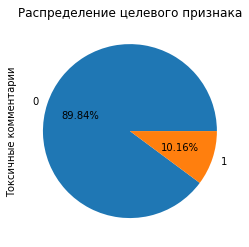

In [6]:
df['toxic'].value_counts().plot(kind='pie', ylabel='Токсичные комментарии', 
                                autopct='%1.2f%%', title='Распределение целевого признака')
plt.show()

В датасете 159292 комментария. Из них 10.16% негативные, 89.84% позитивные.

### Подготовка данных
Очистим текст от лишних слов, используя регулярные выражения.

In [7]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text).lower()
    text = text.split()
    return " ".join(text)

In [8]:
df['text_clean'] = df['text'].apply(clear_text)
df[['text', 'text_clean']].sample(5, random_state=42)

,text,text_clean
31055,"Sometime back, I just happened to log on to ww...",sometime back i just happened to log on to www...
102929,"""\n\nThe latest edit is much better, don't mak...",the latest edit is much better don t make this...
67385,""" October 2007 (UTC)\n\nI would think you'd be...",october utc i would think you d be able to get...
81167,Thanks for the tip on the currency translation...,thanks for the tip on the currency translation...
90182,I would argue that if content on the Con in co...,i would argue that if content on the con in co...


Лемматизируем текст, используя spaCy.

In [9]:
nlp = en_core_web_sm.load()
def lemmatize(text):
    temp = []
    for token in nlp(text):
        if token.is_stop == False:
            temp.append(token.lemma_)
    return " ".join(temp)

In [10]:
tqdm.pandas()
df['text_lemma'] = df['text_clean'].progress_apply(lemmatize)

100%|██████████| 159292/159292 [37:00<00:00, 71.74it/s] 


In [11]:
df[['text', 'text_clean', 'text_lemma']].sample(5, random_state=42)

,text,text_clean,text_lemma
31055,"Sometime back, I just happened to log on to ww...",sometime back i just happened to log on to www...,happen log www izoom friend s reference amazed...
102929,"""\n\nThe latest edit is much better, don't mak...",the latest edit is much better don t make this...,late edit well don t article state super
67385,""" October 2007 (UTC)\n\nI would think you'd be...",october utc i would think you d be able to get...,october utc think d able point immune objectio...
81167,Thanks for the tip on the currency translation...,thanks for the tip on the currency translation...,thank tip currency translation think s
90182,I would argue that if content on the Con in co...,i would argue that if content on the con in co...,argue content con comparison art music proport...


Разобьем данные на выборки.

In [12]:
# обозначим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [13]:
# разобьем данные на тренировочные и тестовые
train, test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train = train['text_lemma']
y_train = train['toxic']
X_test = test['text_lemma']
y_test = test['toxic']

Проведем TF-IDF векторизацию и удалим стоп-слова.

In [14]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
stopwords=list(stopwords)
 
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_model = count_tf_idf.fit(X_train)
train_tfidf = count_tf_idf.transform(X_train)
test_tfidf = count_tf_idf.transform(X_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
print(f"Размер тренировочного датасета: {train_tfidf.shape}")
print(f"Размер тестового датасета: {test_tfidf.shape}")

Размер тренировочного датасета: (119469, 126999)
Размер тестового датасета: (39823, 126999)


### Вывод

В датасете 159292 комментария. Из них 10.16% негативные, 89.84% позитивные.

Мы провели следующую подготовку данных:
* Удалили из текста лищние символы (пунктуация, лишние пробелы)
* Провели лемматизацию слов с помощью SpaCy
* Удалили стоп-слова
* Провели векторизацию корпусов с помощью TfidfVectorizer

## Обучение
Обучим разные модели и выберем лучшую.

### Модель логистической регрессии

In [16]:
# инициализируем модель
log_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

# создаём словарь со значениями гиперпараметров для перебора
log_parameters = {
    'max_iter': [500, 1000]
} 

log_search = RandomizedSearchCV(
    log_model,
    log_parameters,
    n_jobs=-1,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE
)

log_search.fit(train_tfidf, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=42),
                   n_jobs=-1, param_distributions={'max_iter': [500, 1000]},
                   random_state=42, scoring='f1')

In [19]:
log_f1 = np.round(log_search.best_score_, 3)
print(f'Метрика F1 при кросс-валидации: {log_f1}')
print(f'Параметры для лучшей модели: {log_search.best_params_}')

Метрика F1 при кросс-валидации: 0.751
Параметры для лучшей модели: {'max_iter': 500}


### Модель KNeighborsClassifier

In [20]:
# инициализируем модель
kneighbors_model = KNeighborsClassifier()

# создаём словарь со значениями гиперпараметров для перебора
kneighbors_parameters = {
        'n_neighbors': range(2, 5)
    }
 

kneighbors_search = RandomizedSearchCV(
    kneighbors_model,
    kneighbors_parameters,
    n_jobs=-1,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE
)

kneighbors_search.fit(train_tfidf, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': range(2, 5)},
                   random_state=42, scoring='f1')

In [22]:
kneighbors_f1 = np.round(kneighbors_search.best_score_, 3)
print(f'Метрика F1 при кросс-валидации: {kneighbors_f1}')
print(f'Параметры для лучшей модели: {kneighbors_search.best_params_}')

Метрика F1 при кросс-валидации: 0.307
Параметры для лучшей модели: {'n_neighbors': 3}


### Модель CatBoost

In [23]:
# инициализируем модель
cat_model = CatBoostClassifier(random_state=RANDOM_STATE)

# создаём словарь со значениями гиперпараметров для перебора
cat_parameters = {
        'iterations': [10, 100],
        'max_depth': [10, 20]
    }
 

cat_search = RandomizedSearchCV(
    cat_model,
    cat_parameters,
    n_jobs=-1,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE
)

cat_search.fit(train_tfidf, y_train)

Learning rate set to 0.5
0:	learn: 0.3382943	total: 14s	remaining: 2m 6s
1:	learn: 0.2464975	total: 27.7s	remaining: 1m 50s
2:	learn: 0.2184602	total: 41.7s	remaining: 1m 37s
3:	learn: 0.2044095	total: 55.5s	remaining: 1m 23s
4:	learn: 0.1952476	total: 1m 9s	remaining: 1m 9s
5:	learn: 0.1854749	total: 1m 23s	remaining: 55.6s
6:	learn: 0.1803259	total: 1m 37s	remaining: 41.6s
7:	learn: 0.1758891	total: 1m 51s	remaining: 27.8s
8:	learn: 0.1720860	total: 2m 4s	remaining: 13.9s
9:	learn: 0.1689024	total: 2m 18s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3379218	total: 14.4s	remaining: 2m 9s
1:	learn: 0.2505130	total: 28.9s	remaining: 1m 55s
2:	learn: 0.2184118	total: 43.4s	remaining: 1m 41s
3:	learn: 0.2040783	total: 58s	remaining: 1m 26s
4:	learn: 0.1945159	total: 1m 12s	remaining: 1m 12s
5:	learn: 0.1863840	total: 1m 27s	remaining: 58.1s
6:	learn: 0.1813660	total: 1m 41s	remaining: 43.5s
7:	learn: 0.1766023	total: 1m 55s	remaining: 28.9s
8:	learn: 0.1719474	total: 2m 10s	remaini

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fbb1034d820>,
                   n_jobs=-1,
                   param_distributions={'iterations': [10, 100],
                                        'max_depth': [10, 20]},
                   random_state=42, scoring='f1')

In [24]:
cat_f1 = np.round(cat_search.best_score_, 3)
print(f'Метрика F1 при кросс-валидации: {cat_f1}')
print(f'Параметры для лучшей модели: {cat_search.best_params_}')

Метрика F1 при кросс-валидации: 0.753
Параметры для лучшей модели: {'max_depth': 10, 'iterations': 100}


### Анализ лучшей модели

In [26]:
models_results = pd.DataFrame({'model': ['LogisticRegression', 'KNeighborsClassifier', 'CatBoostClassifier'], 
  'F1': [log_f1, kneighbors_f1, cat_f1]})

models_results

,model,F1
0,LogisticRegression,0.751
1,KNeighborsClassifier,0.307
2,CatBoostClassifier,0.753


Лучшей моделью является CatBoostClassifier с гиперпараметрами: max_depth = 10, iterations = 100

### Тестирование лучшей модели
Выполним предсказание на тестовых данных.

In [28]:
y_pred_cat = cat_search.predict(test_tfidf)
print(f'Метрика F1 на тестовой выборке: {np.round(f1_score(y_test, y_pred_cat), 2)}')

Метрика F1 на тестовой выборке: 0.76


Результат укладывается в заданное нам условие: метрика F1 не меньше 0.75.

## Выводы

Нашей целью было обучить модель классифицировать комментарии на позитивные и негативные.

Датасет был представлен 159292 комментариями. Из них 10.16% негативные, 89.84% позитивные.

Мы провели следующую подготовку данных:
* Удалили из текста лищние символы (пунктуация, лишние пробелы)
* Провели лемматизацию слов с помощью SpaCy
* Удалили стоп-слова
* Провели векторизацию корпусов с помощью TfidfVectorizer

Обучили три модели, подобрав им гиперпараметры:
* LogisticRegression()
* KNeighborsClassifier()
* CatBoostClassifier()

Лучшей моделью является CatBoostClassifier с гиперпараметрами: max_depth = 10, iterations = 100

Метрика F1 лучшей модели на тестовой выборке 0.76, что укладывается в заданное нам условие.